# Breast Cancer Survival Analysis 

### Installing Packages

In [1]:
!pip install lifelines

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.7/349.7 KB 14.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 KB 8.9 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4048 sha256=17667710a992ebeb8158c328c1dbbcbeb272bbd36e2bbc64f0012c6b02077a7e
  Stored in directory: /root/.cache/pip/wheels/16/a2/b6/582cfdfbeeccd469504a01af3bb952fd9e7eccba40995eafea
Successfully built autograd-gamma


### Importing Libraries

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

from scipy.stats import mode
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score
from lifelines import KaplanMeierFitter
from lifelines.utils import concordance_index

import matplotlib.pyplot as plt
import seaborn as sns

### Loading Dataset from Google Drive

In [3]:
from google.colab import drive
drive.mount('/drive')
path='/drive/My Drive/Colab Notebooks/breastCancerData.csv'


Mounted at /drive


In [4]:
data = pd.read_csv(path)

print('Dataset Shape:',data.shape)


Dataset Shape: (2509, 34)


## Preprocessing of DataSet

### Overview of DataSet

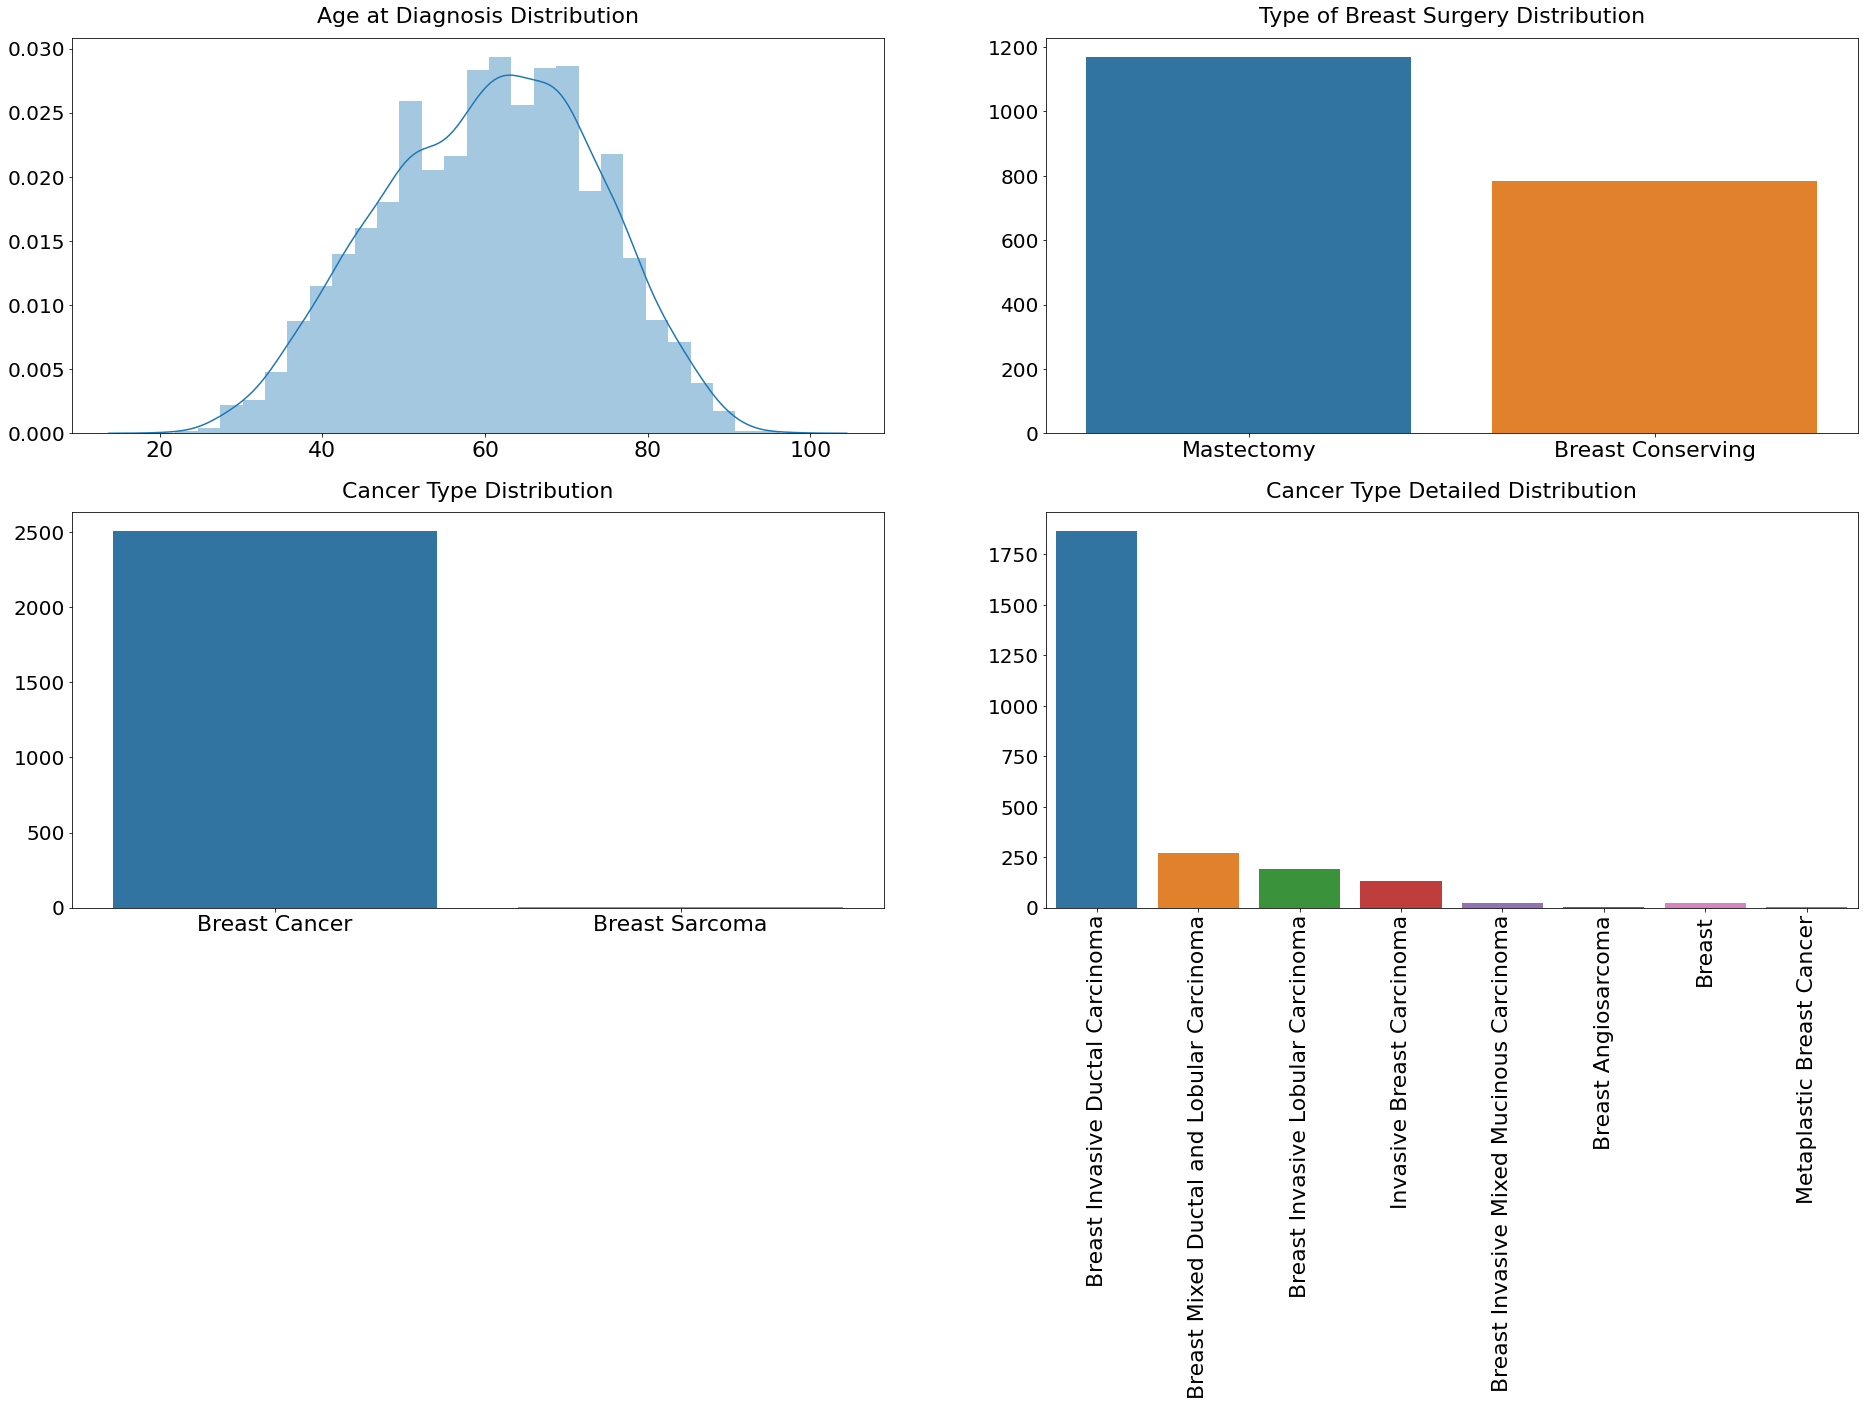

In [5]:
fig, axes = plt.subplots(figsize=(32, 16), ncols=2, nrows=2)

sns.distplot(data['Age at Diagnosis'], ax=axes[0][0])
sns.countplot(data['Type of Breast Surgery'], ax=axes[0][1])
sns.countplot(data['Cancer Type'], ax=axes[1][0])
sns.countplot(data['Cancer Type Detailed'], ax=axes[1][1])

for i in range(2):
    for j in range(2):
        if i == 1 and j == 1:
            axes[i][j].tick_params(axis='x', labelsize=22, rotation=90)
        else:
            axes[i][j].tick_params(axis='x', labelsize=22)
        axes[i][j].tick_params(axis='y', labelsize=20)
        
        axes[i][j].set_xlabel('')
        axes[i][j].set_ylabel('')
        
axes[0][0].set_title('Age at Diagnosis Distribution', size=22, pad=15)
axes[0][1].set_title('Type of Breast Surgery Distribution', size=22, pad=15)
axes[1][0].set_title('Cancer Type Distribution', size=22, pad=15)
axes[1][1].set_title('Cancer Type Detailed Distribution', size=22, pad=15)

plt.show()

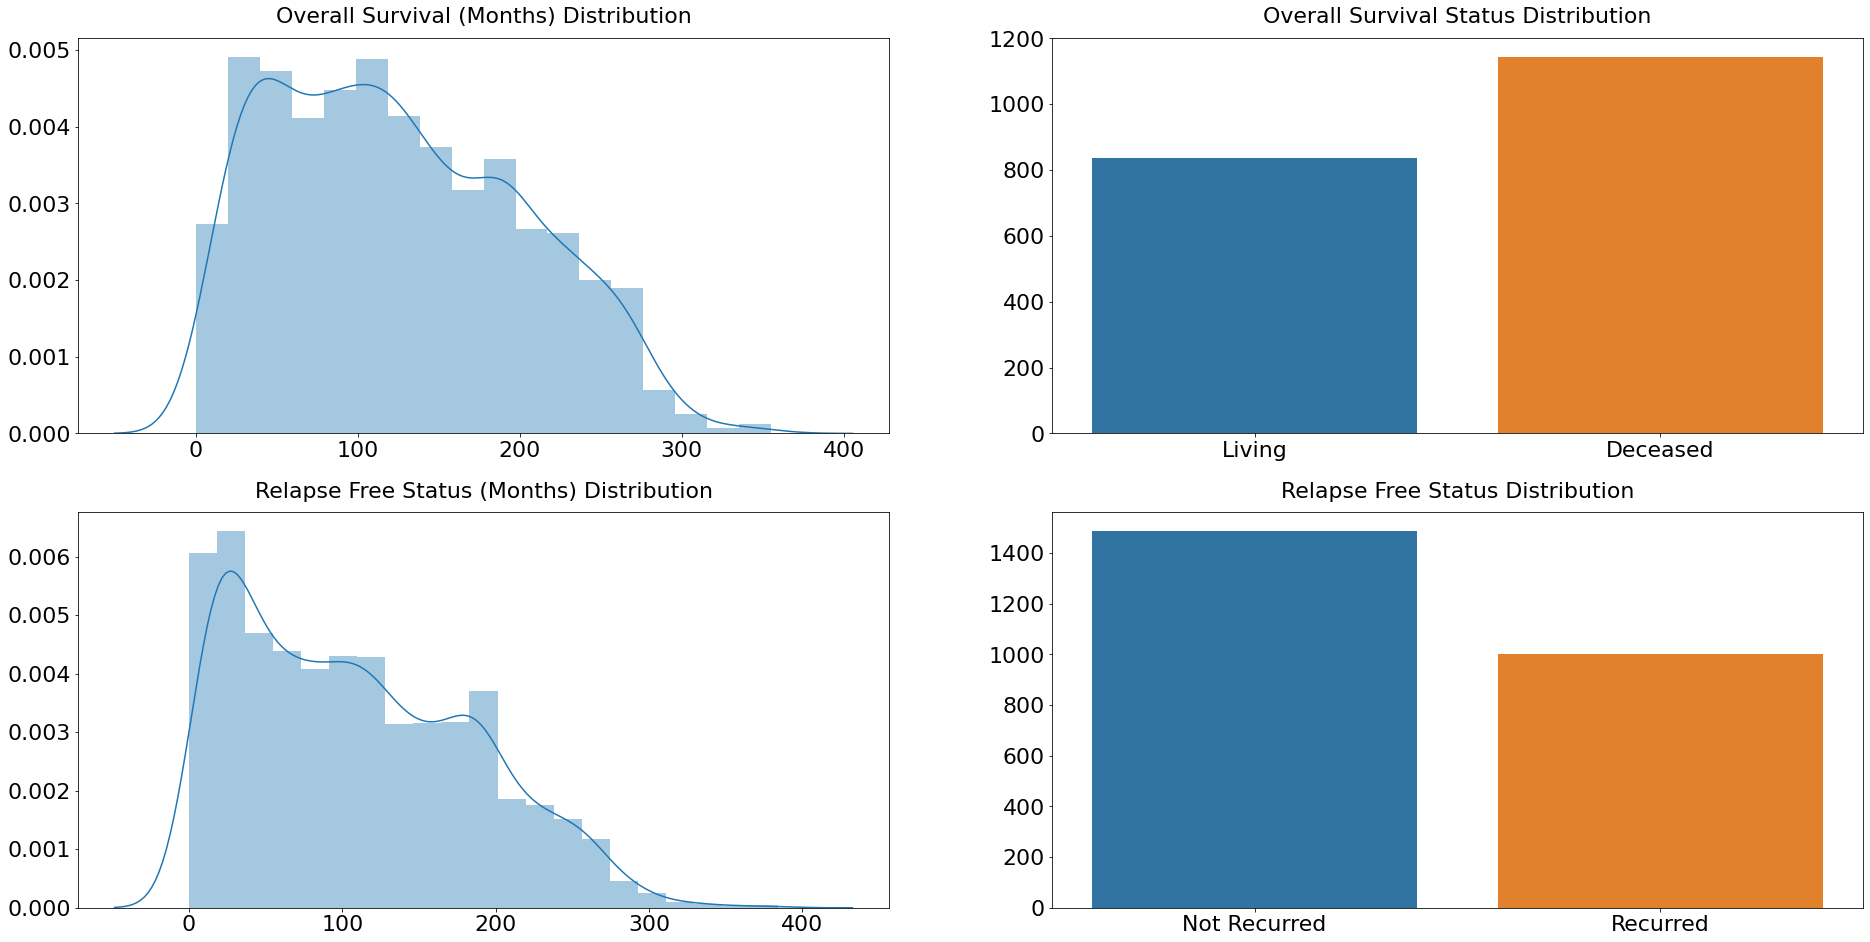

In [6]:
fig, axes = plt.subplots(figsize=(32, 16), ncols=2, nrows=2)

sns.distplot(data['Overall Survival (Months)'], ax=axes[0][0])
sns.countplot(data['Overall Survival Status'], ax=axes[0][1])
sns.distplot(data['Relapse Free Status (Months)'], ax=axes[1][0])
sns.countplot(data['Relapse Free Status'], ax=axes[1][1])

for i in range(2):
    for j in range(2):
        if i == 1 and j == 1:
            axes[i][j].tick_params(axis='x', labelsize=22)
        else:
            axes[i][j].tick_params(axis='x', labelsize=22)
        axes[i][j].tick_params(axis='y', labelsize=22)
        
        axes[i][j].set_xlabel('')
        axes[i][j].set_ylabel('')
        
axes[0][0].set_title('Overall Survival (Months) Distribution', size=22, pad=15)
axes[0][1].set_title('Overall Survival Status Distribution', size=22, pad=15)
axes[1][0].set_title('Relapse Free Status (Months) Distribution', size=22, pad=15)
axes[1][1].set_title('Relapse Free Status Distribution', size=22, pad=15)

plt.show()

In [7]:
data.head()

,Patient ID,Age at Diagnosis,Type of Breast Surgery,Cancer Type,Cancer Type Detailed,Cellularity,Chemotherapy,Pam50 + Claudin-low subtype,Cohort,ER status measured by IHC,ER Status,Neoplasm Histologic Grade,HER2 status measured by SNP6,HER2 Status,Tumor Other Histologic Subtype,Hormone Therapy,Inferred Menopausal State,Integrative Cluster,Primary Tumor Laterality,Lymph nodes examined positive,Mutation Count,Nottingham prognostic index,Oncotree Code,Overall Survival (Months),Overall Survival Status,PR Status,Radio Therapy,Relapse Free Status (Months),Relapse Free Status,Sex,3-Gene classifier subtype,Tumor Size,Tumor Stage,Patient's Vital Status
0,MB-0000,75.65,Mastectomy,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,No,claudin-low,1.0,Positve,Positive,3.0,Neutral,Negative,Ductal/NST,Yes,Post,4ER+,Right,10.0,NaN,6.044,IDC,140.500000,Living,Negative,Yes,138.65,Not Recurred,Female,ER-/HER2-,22.0,2.0,Living
1,MB-0002,43.19,Breast Conserving,Breast Cancer,Breast Invasive Ductal Carcinoma,High,No,LumA,1.0,Positve,Positive,3.0,Neutral,Negative,Ductal/NST,Yes,Pre,4ER+,Right,0.0,2.0,4.020,IDC,84.633333,Living,Positive,Yes,83.52,Not Recurred,Female,ER+/HER2- High Prolif,10.0,1.0,Living
2,MB-0005,48.87,Mastectomy,Breast Cancer,Breast Invasive Ductal Carcinoma,High,Yes,LumB,1.0,Positve,Positive,2.0,Neutral,Negative,Ductal/NST,Yes,Pre,3,Right,1.0,2.0,4.030,IDC,163.700000,Deceased,Positive,No,151.28,Recurred,Female,NaN,15.0,2.0,Died of Disease
3,MB-0006,47.68,Mastectomy,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,Yes,LumB,1.0,Positve,Positive,2.0,Neutral,Negative,Mixed,Yes,Pre,9,Right,3.0,1.0,4.050,MDLC,164.933333,Living,Positive,Yes,162.76,Not Recurred,Female,NaN,25.0,2.0,Living
4,MB-0008,76.97,Mastectomy,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,Yes,LumB,1.0,Positve,Positive,3.0,Neutral,Negative,Mixed,Yes,Post,9,Right,8.0,2.0,6.080,MDLC,41.366667,Deceased,Positive,Yes,18.55,Recurred,Female,ER+/HER2- High Prolif,40.0,2.0,Died of Disease


### Preprocessing and Cleaning

                        

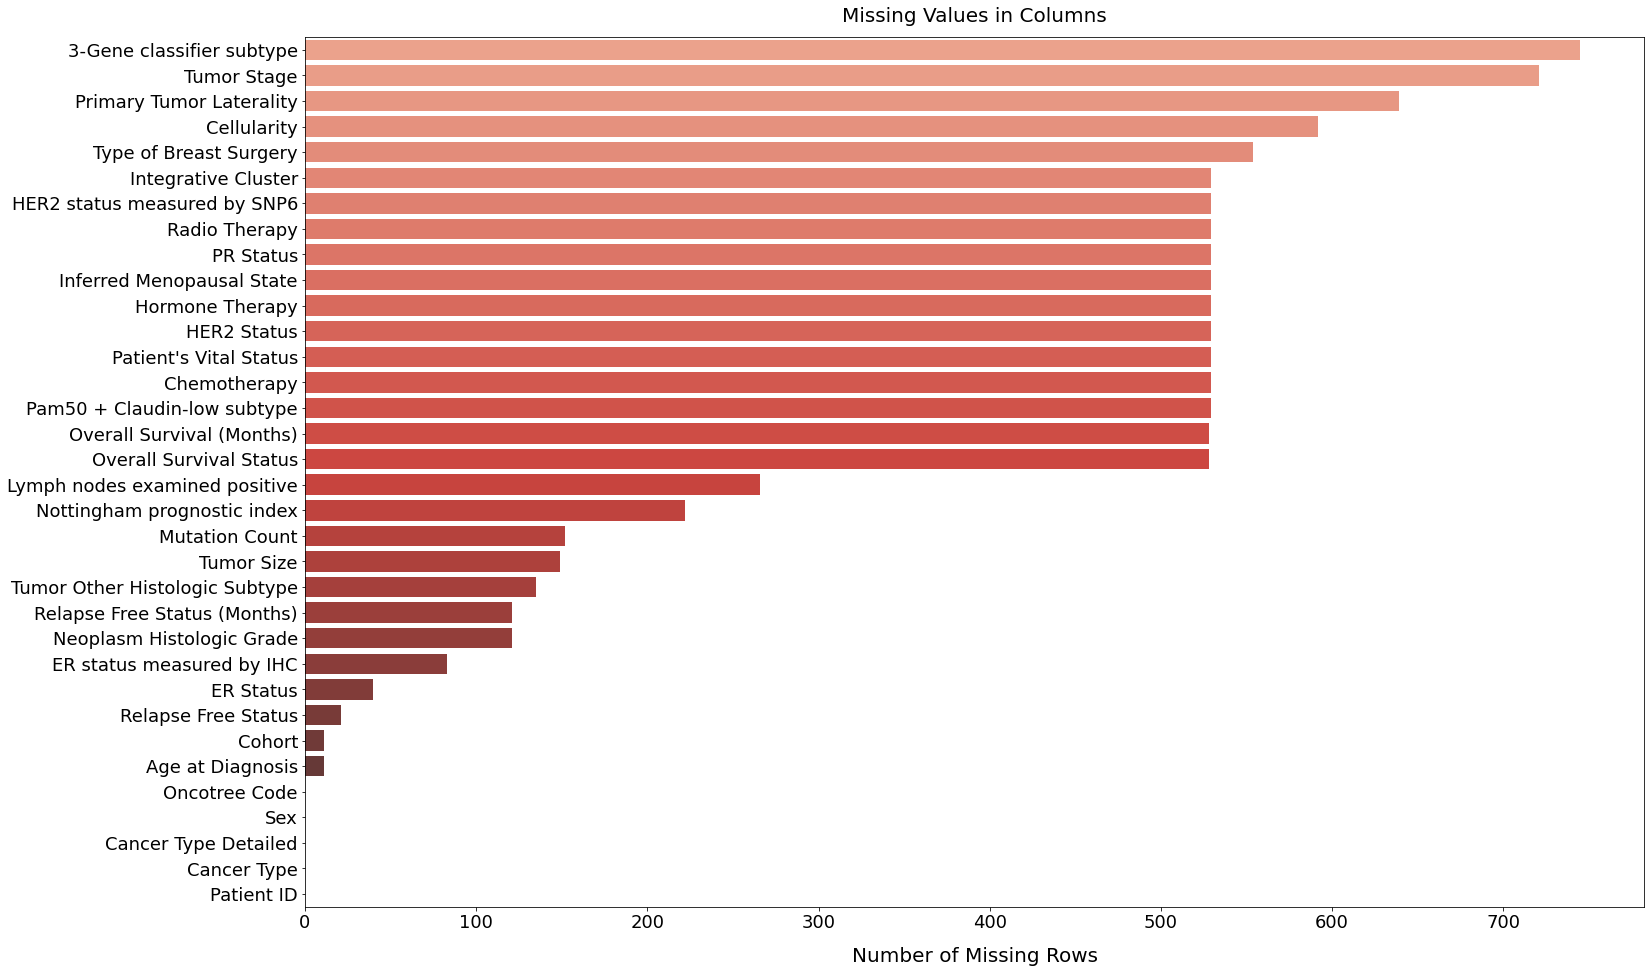

In [8]:
fig = plt.figure(figsize=(24, 16))

sns.barplot(x=data.isnull().sum().sort_values(ascending=False).values,
            y=data.isnull().sum().sort_values(ascending=False).index,
            palette='Reds_d')

plt.xlabel('Number of Missing Rows', size=20, labelpad=15)
plt.ylabel('')
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)
plt.title('Missing Values in Columns', size=20, pad=15)

plt.show()

### Adding data in missing fields

In [9]:

# Event and duration columns

data['Relapse Free Status'] = data.groupby(['Cancer Type Detailed'])['Relapse Free Status'].apply(lambda x: x.fillna(mode(x)[0][0]))
data['Relapse Free Status (Months)'] = data.groupby(['Cancer Type Detailed', 'Relapse Free Status'])['Relapse Free Status (Months)'].apply(lambda x: x.fillna(x.mean()))
data['Overall Survival Status'] = data.groupby(['Cancer Type Detailed', 'Relapse Free Status'])['Overall Survival Status'].apply(lambda x: x.fillna(mode(x)[0][0]))
data['Overall Survival (Months)'] = data.groupby(['Cancer Type Detailed', 'Overall Survival Status'])['Overall Survival (Months)'].apply(lambda x: x.fillna(x.mean()))

# ER, PR, HER2 status columns
data['ER status measured by IHC'] = data['ER status measured by IHC'].fillna(mode(data['ER status measured by IHC'])[0][0])
data['ER Status'] = data.groupby(['ER status measured by IHC'])['ER Status'].apply(lambda x: x.fillna(mode(x)[0][0]))
data['HER2 status measured by SNP6'] = data['HER2 status measured by SNP6'].fillna(mode(data['HER2 status measured by SNP6'])[0][0])
data['HER2 Status'] = data.groupby(['HER2 status measured by SNP6'])['HER2 Status'].apply(lambda x: x.fillna(mode(x)[0][0]))
data['PR Status'] = data.groupby(['Cancer Type Detailed'])['PR Status'].apply(lambda x: x.fillna(mode(x)[0][0]))

# Chemotherapy, Hormone Therapy, Radio Therapy columns
data['Chemotherapy'] = data.groupby(['Cancer Type Detailed'])['Chemotherapy'].apply(lambda x: x.fillna(mode(x)[0][0]))
data['Hormone Therapy'] = data.groupby(['Cancer Type Detailed'])['Hormone Therapy'].apply(lambda x: x.fillna(mode(x)[0][0]))
data['Radio Therapy'] = data.groupby(['Cancer Type Detailed'])['Radio Therapy'].apply(lambda x: x.fillna(mode(x)[0][0]))

# Other columns
data['Age at Diagnosis'] = data.groupby(['Cancer Type Detailed'])['Age at Diagnosis'].apply(lambda x: x.fillna(x.mean()))
data['Cohort'] = data.groupby(['Cancer Type Detailed'])['Cohort'].apply(lambda x: x.fillna(x.median()))
data['Cellularity'] = data.groupby(['Cancer Type Detailed'])['Cellularity'].apply(lambda x: x.fillna(mode(x)[0][0]))
data['Tumor Stage'] = data.groupby(['Cancer Type Detailed', 'Cellularity'])['Tumor Stage'].apply(lambda x: x.fillna(x.median()))
data['Tumor Stage'] = data.groupby(['Cancer Type Detailed'])['Tumor Stage'].apply(lambda x: x.fillna(x.median()))
data['Tumor Size'] = data.groupby(['Cancer Type Detailed', 'Tumor Stage'])['Tumor Size'].apply(lambda x: x.fillna(x.median()))
data['Tumor Size'] = data.groupby(['Cancer Type Detailed'])['Tumor Size'].apply(lambda x: x.fillna(x.median()))
data['Tumor Size'] = data['Tumor Size'].fillna(mode(data['Tumor Size'])[0][0])
data['Neoplasm Histologic Grade'] = data.groupby(['Cancer Type Detailed'])['Neoplasm Histologic Grade'].apply(lambda x: x.fillna(x.mode()))
data['Neoplasm Histologic Grade'] = data['Neoplasm Histologic Grade'].fillna(mode(data['Neoplasm Histologic Grade'])[0][0])
data['Primary Tumor Laterality'] = data.groupby(['Cancer Type Detailed'])['Primary Tumor Laterality'].apply(lambda x: x.fillna(x.mode()))
data['Tumor Other Histologic Subtype'] = data.groupby(['Cancer Type Detailed'])['Tumor Other Histologic Subtype'].apply(lambda x: x.fillna(x.mode()))
data['Tumor Other Histologic Subtype'] = data['Tumor Other Histologic Subtype'].fillna('Ductal/NST')
data['Mutation Count'] = data.groupby(['Cancer Type Detailed'])['Mutation Count'].apply(lambda x: x.fillna(x.mode()))
data['Mutation Count'] = data['Mutation Count'].fillna(mode(data['Mutation Count'])[0][0])
data['Nottingham prognostic index'] = data.groupby(['Tumor Size'])['Nottingham prognostic index'].apply(lambda x: x.fillna(x.median()))
data['Nottingham prognostic index'] = data['Nottingham prognostic index'].fillna(data['Nottingham prognostic index'].median())
data['Lymph nodes examined positive'] = data.groupby(['Cancer Type Detailed'])['Lymph nodes examined positive'].apply(lambda x: x.fillna(x.mode()))
data['Lymph nodes examined positive'] = data['Lymph nodes examined positive'].fillna(mode(data['Lymph nodes examined positive'])[0][0])
data['Inferred Menopausal State'] = data['Inferred Menopausal State'].fillna(mode(data['Inferred Menopausal State'])[0][0])
data['Pam50 + Claudin-low subtype'] = data.groupby(['Cancer Type Detailed'])['Pam50 + Claudin-low subtype'].apply(lambda x: x.fillna(mode(x)[0][0]))
data['Integrative Cluster'] = data.groupby(['Cancer Type Detailed'])['Cellularity'].apply(lambda x: x.fillna(mode(x)[0][0]))
data['Type of Breast Surgery'] = data.groupby(['Cancer Type Detailed'])['Type of Breast Surgery'].apply(lambda x: x.fillna(mode(x)[0][0]))
data['Primary Tumor Laterality'] = data.groupby(['Cancer Type Detailed'])['Primary Tumor Laterality'].apply(lambda x: x.fillna(mode(x)[0][0]))
data['3-Gene classifier subtype'] = data.groupby(['Cancer Type Detailed'])['3-Gene classifier subtype'].apply(lambda x: x.fillna(mode(x)[0][0]))

data.drop(columns=["Patient's Vital Status"], inplace=True)

### Labeling Data

Overall Survival Status

> Living -> 0

> Deceased -> 1


Relapse Free Status


> Not Recurred -> 0


> Recurred -> 1






In [10]:
object_cols = ['Type of Breast Surgery', 'Cancer Type', 'Cancer Type Detailed', 'Cellularity',
               'Chemotherapy', 'Chemotherapy', 'Pam50 + Claudin-low subtype', 'ER status measured by IHC',
               'ER Status', 'HER2 status measured by SNP6', 'HER2 Status', 'Tumor Other Histologic Subtype',
               'Hormone Therapy', 'Inferred Menopausal State', 'Integrative Cluster', 'Primary Tumor Laterality',
               'Oncotree Code', 'PR Status', 'Radio Therapy', 'Sex', '3-Gene classifier subtype']

for col in object_cols:
    data[col] = np.uint8(LabelEncoder().fit_transform(data[col]))
    
data['Overall Survival Status'] = np.uint8(data['Overall Survival Status'].map({'Living': 0, 'Deceased': 1}))
data['Relapse Free Status'] = np.uint8(data['Relapse Free Status'].map({'Not Recurred': 0, 'Recurred': 1}))

### Correlations of features

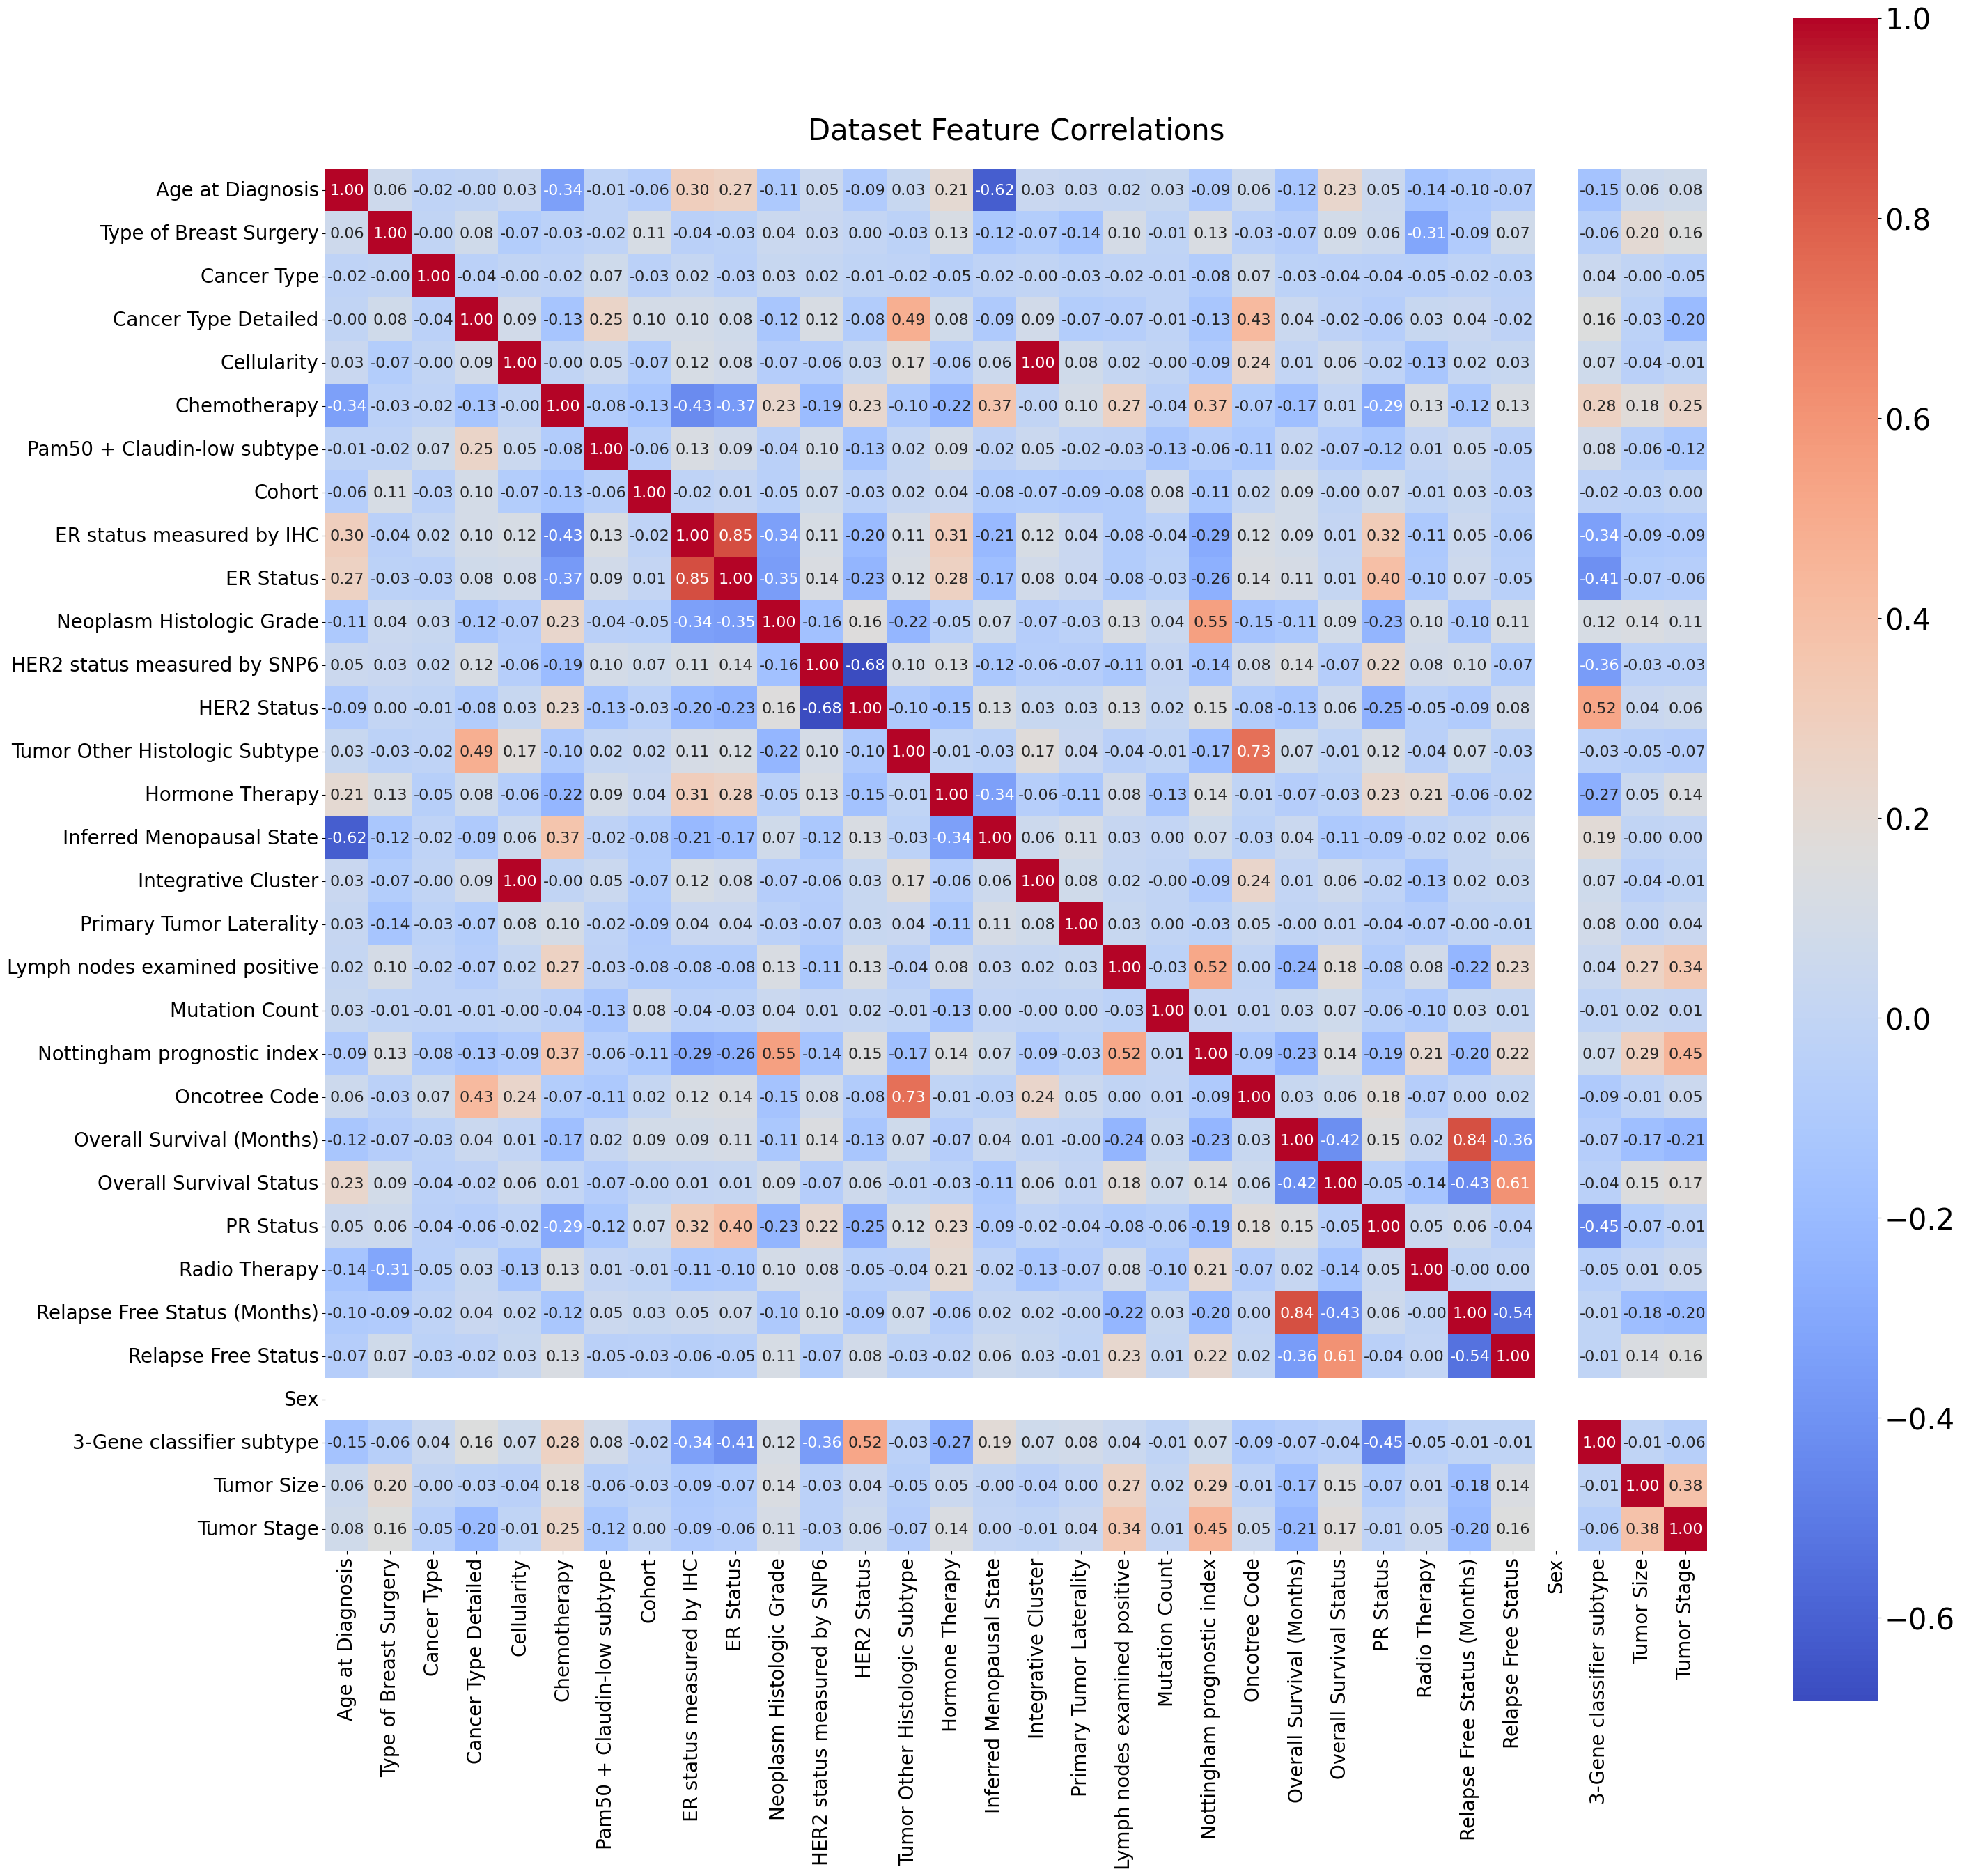

In [11]:
fig = plt.figure(figsize=(32, 32), dpi=100)

ax = sns.heatmap(data.corr(), annot=True, square=True, cmap='coolwarm', annot_kws={'size': 16},  fmt='.2f')
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=30)

plt.tick_params(axis='x', labelsize=20, rotation=90)
plt.tick_params(axis='y', labelsize=20, rotation=0)
plt.title('Dataset Feature Correlations', size=30, pad=30)

plt.show()

In [12]:
data.drop(columns=['Integrative Cluster'], inplace=True)

## Censoring





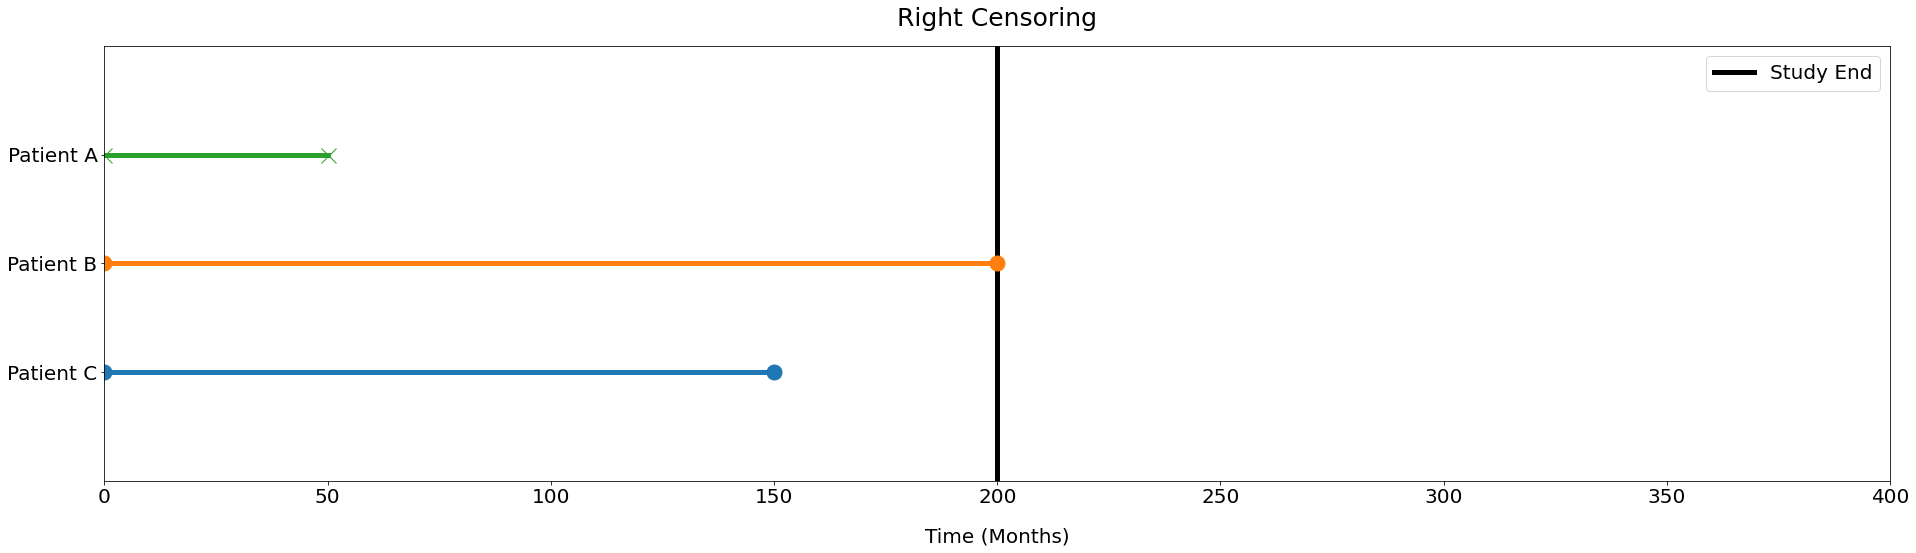

In [13]:
fig = plt.figure(figsize=(32, 8))

plt.xlim(0, 400), plt.ylim(0, 4)
plt.axvline(200, color='black', label='Study End', linewidth=5)
plt.plot([0, 150], [1, 1], marker='o', markersize=15, linewidth=5)
plt.plot([0, 200], [2, 2], marker='o', markersize=15, linewidth=5)
plt.plot([0, 50], [3, 3], marker='x', markersize=15, linewidth=5)

plt.xlabel('Time (Months)', size=20, labelpad=20)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.yticks([1, 2, 3], ['Patient C', 'Patient B', 'Patient A'])
plt.legend(prop={'size': 20})
plt.title('Right Censoring', size=25, pad=20)

plt.show()

## Evaluation



In [14]:
def td_roc_auc(y_true, y_pred, survival_times):
    td_y_true = pd.DataFrame(data=np.zeros((y_pred.shape[0], y_pred.shape[1])),
                                         index=y_true.index,
                                         columns=y_pred.columns,
                                         dtype=np.uint8)

    for i, time in enumerate(y_pred.columns):
        td_y_true.iloc[:, i] = ((y_true == 1) & (time >= survival_times)).astype(np.uint8)

    scores = {}
    for time in y_pred.columns:
        score = np.round(roc_auc_score(td_y_true[time], y_pred[time]), 6)
        scores[int(time)] = score

    return scores


## Survival Model


In [15]:
data_train, data_test = train_test_split(data,
                                     test_size=0.2,
                                     stratify=data['Cancer Type Detailed'],
                                     shuffle=True,
                                     random_state=0)

data_train.reset_index(drop=True, inplace=True)
data_test.reset_index(drop=True, inplace=True)

n_splits = 5
stratiKFold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)
for fold, (_, val_idx) in enumerate(stratiKFold.split(data_train, data_train['Cancer Type Detailed']), 1):
    data_train.loc[val_idx, 'fold'] = fold

data_train['fold'] = data_train['fold'].astype(np.uint8)

## Kaplan-Meier Estimate (Non-parametric Model)



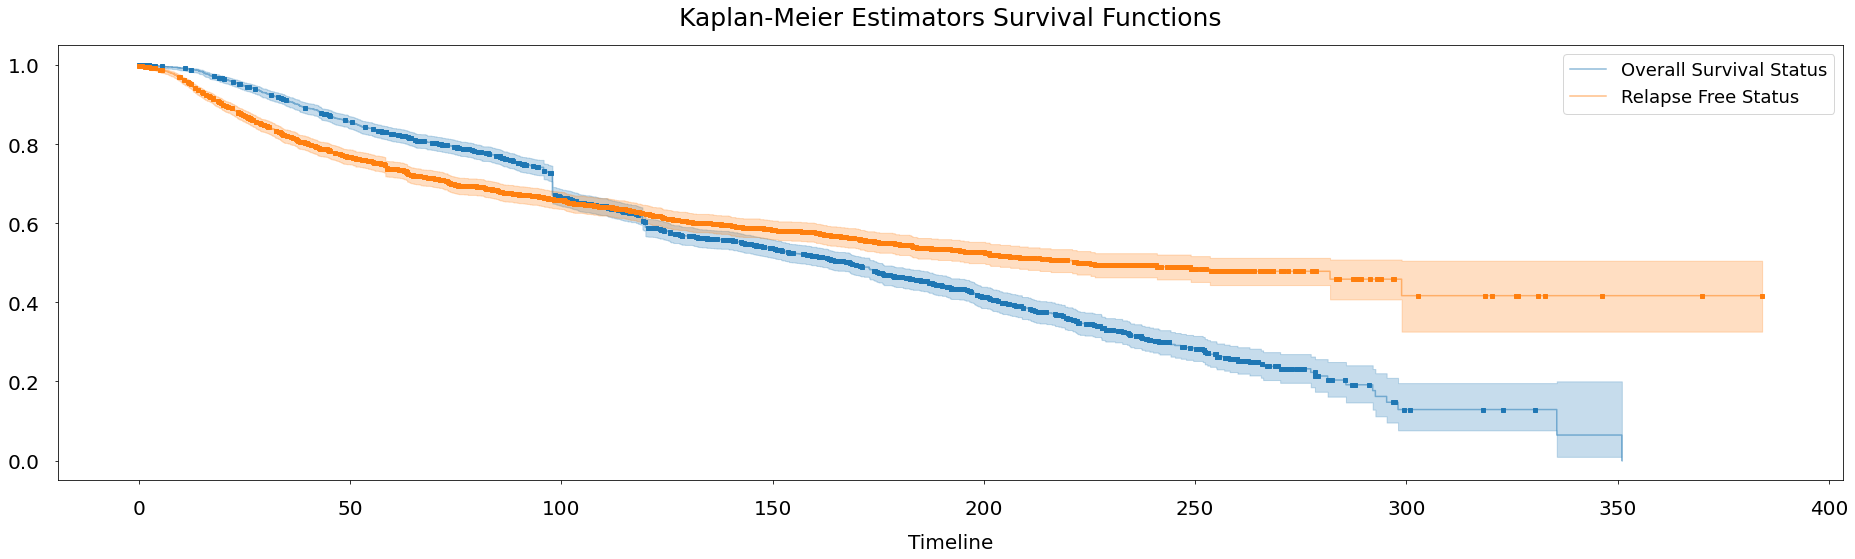

In [16]:
fig = plt.figure(figsize=(32, 8))

for time, event in zip(['Overall Survival (Months)', 'Relapse Free Status (Months)'], ['Overall Survival Status', 'Relapse Free Status']):
       
    T, E = data_train[time], data_train[event]
    kmfitter = KaplanMeierFitter()
    kmfitter.fit(T, E)
    kmfitter.plot(label=event, alpha=0.5, show_censors=True, censor_styles={'ms': 4, 'marker': 's'})
    
plt.xlabel('Timeline', size=20, labelpad=15)
plt.ylabel('')
plt.tick_params(axis='x', labelsize=20, pad=15)
plt.tick_params(axis='y', labelsize=20, pad=15)
plt.legend(prop={'size': 18})
plt.title('Kaplan-Meier Estimators Survival Functions', size=25, pad=20)

plt.show()

## Predicting from model

In [17]:
evaluationtimes = [12, 24, 36]

for time, event in zip(['Overall Survival (Months)', 'Relapse Free Status (Months)'], ['Overall Survival Status', 'Relapse Free Status']):
    
    oof_survival_function = pd.DataFrame(data=np.zeros((data_train.shape[0], len(evaluationtimes))),
                                                index=data_train.index,
                                                columns=evaluationtimes)
    test_survival_function = pd.DataFrame(data=np.zeros((data_test.shape[0], len(evaluationtimes))),
                                             index=data_test.index,
                                             columns=evaluationtimes)
    
    for fold in sorted(data_train['fold'].unique()):
                    
        trn_idx, val_idx = data_train.loc[data_train['fold'] != fold].index, data_train.loc[data_train['fold'] == fold].index       
        T_trn, E_trn = data_train.loc[trn_idx, time], data_train.loc[trn_idx, event]
        T_val, E_val = data_train.loc[val_idx, time], data_train.loc[val_idx, event]
        kmfitter = KaplanMeierFitter()
        kmfitter.fit(T_trn, E_trn)
        
        survival_function = kmfitter.predict(times=evaluationtimes)        
        val_survival_function = pd.DataFrame(data=np.transpose(np.tile(survival_function.values.reshape(-1, 1), T_val.shape[0])),
                                             index=val_idx,
                                             columns=evaluationtimes)        
        oof_survival_function.loc[val_idx, :] = val_survival_function.values        
        test_survival_function = pd.DataFrame(data=np.transpose(np.tile(survival_function.values.reshape(-1, 1), data_test.shape[0])),
                                              index=data_test.index,
                                              columns=evaluationtimes)
        test_survival_function += (test_survival_function.values / n_splits)

        val_auc = td_roc_auc(data_train.loc[val_idx, event], val_survival_function, data_train.loc[val_idx, time])
        print(f'Fold {fold} ({time}) - ROC AUC Scores {val_auc}')
        
    oof_auc = td_roc_auc(data_train[event], oof_survival_function, data_train[time])
    test_auc = td_roc_auc(data_test[event], test_survival_function, data_test[time])
    print(f'{"-" * 30}\nKaplan Meier Estimate {time} OOF AUC: {oof_auc}')
    print(f'Kaplan-Meier Estimate {time} Test AUC: {test_auc}\n{"-" * 30}\n')


Fold 1 (Overall Survival (Months)) - ROC AUC Scores {12: 0.5, 24: 0.5, 36: 0.5}
Fold 2 (Overall Survival (Months)) - ROC AUC Scores {12: 0.5, 24: 0.5, 36: 0.5}
Fold 3 (Overall Survival (Months)) - ROC AUC Scores {12: 0.5, 24: 0.5, 36: 0.5}
Fold 4 (Overall Survival (Months)) - ROC AUC Scores {12: 0.5, 24: 0.5, 36: 0.5}
Fold 5 (Overall Survival (Months)) - ROC AUC Scores {12: 0.5, 24: 0.5, 36: 0.5}
------------------------------
Kaplan Meier Estimate Overall Survival (Months) OOF AUC: {12: 0.649796, 24: 0.524038, 36: 0.518953}
Kaplan-Meier Estimate Overall Survival (Months) Test AUC: {12: 0.5, 24: 0.5, 36: 0.5}
------------------------------

Fold 1 (Relapse Free Status (Months)) - ROC AUC Scores {12: 0.5, 24: 0.5, 36: 0.5}
Fold 2 (Relapse Free Status (Months)) - ROC AUC Scores {12: 0.5, 24: 0.5, 36: 0.5}
Fold 3 (Relapse Free Status (Months)) - ROC AUC Scores {12: 0.5, 24: 0.5, 36: 0.5}
Fold 4 (Relapse Free Status (Months)) - ROC AUC Scores {12: 0.5, 24: 0.5, 36: 0.5}
Fold 5 (Relapse Fre